In [1]:
import os
import torch
import Attention_GAN
from reglib import reg
import argparse
from torchvision.transforms import functional
from PIL import Image
import numpy as np
import seaborn
import matplotlib.pyplot as plt



/home/jmabq/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='7'
device = torch.device('cuda')

save_root  = '/home/jmabq/projects/VirtualStainingSOTA/Our/assets'
G_path = '/jhcnas1/jmabq/virtual_staining_sota/her2/he2pas_uniform_decouple_noise_3v1/model/netG_epoch_145.pth'
netSR_path = '/jhcnas1/jmabq/virtual_staining_sota/her2/he2pas_uniform_decouple_noise_3v1/model/netSReg_epoch_145.pth'
netDR_path = '/jhcnas1/jmabq/virtual_staining_sota/her2/he2pas_uniform_decouple_noise_3v1/model/netDReg_epoch_145.pth'

# build generator and discriminator
netG = Attention_GAN.Generator(n_channels=64, in_channels=3, batch_norm=False, 
    out_channels=3, padding=1, pooling_mode="maxpool",).to(device)
# define models for registration
RegGT = reg.Reg(128, 128, 3, 3, device, True).to(device)
RegX = reg.Reg(128, 128, 3, 3, device, True).to(device)
spatial_transform = reg.Transformer_2D()


msg = netG.load_state_dict(torch.load(G_path, map_location='cpu'), strict=True)
print(msg)
msg = RegGT.load_state_dict(torch.load(netSR_path, map_location='cpu'), strict=True)
print(msg)
msg = RegX.load_state_dict(torch.load(netDR_path, map_location='cpu'), strict=True)
print(msg)

/home/jmabq/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400412039/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


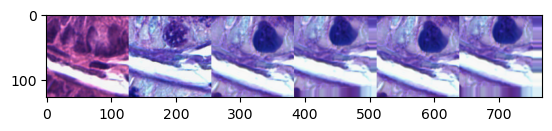

In [10]:
img_path = '/home/jmabq/data/he2pas_uniform/test/a_handled_A-01/137_1855'

angle = 5
translation = [10, 10]
scale = 1.1
shear = [0, 0]

files = os.listdir(img_path)
input_path = files[0] if 'he' in files[0] else files[1]
target_path = files[0] if 'pas' in files[0] else files[1]
input_path = os.path.join(img_path, input_path)
target_path = os.path.join(img_path, target_path)
file_name = os.path.split(img_path)[-1]
save_path = os.path.join(save_root, file_name)

# load img
input_img = Image.open(input_path).convert('RGB')
target_img = Image.open(target_path).convert('RGB')

input_img = functional.affine(input_img, angle, translate=translation, scale=scale, 
                              shear=shear, interpolation=functional.InterpolationMode.BILINEAR)

input_img = functional.center_crop(input_img, (128, 128))
target_img = functional.center_crop(target_img, (128, 128))

input_img = (functional.to_tensor(input_img) - 0.5)*2
target_img = (functional.to_tensor(target_img) - 0.5)*2


input = input_img.to(device)[None]
target = target_img.to(device)[None]

with torch.no_grad():
    rec = netG(input)
    mesh = RegGT(rec, target)
    rec_reg, mask = spatial_transform(rec, mesh)

    same_mesh = RegX(input, rec)
    same_reg, ds_mask = spatial_transform(rec, same_mesh)
    diff_mesh = RegX(input, target)
    diff_reg, dd_mask = spatial_transform(rec, diff_mesh)

i = 0
tmp = [input[i], target[i], rec[i], rec_reg[i], same_reg[i], diff_reg[i]]
tmp = ((torch.cat(tmp, dim=2).cpu().numpy()+1)/2*255).astype('uint8')
tmp = np.transpose(tmp, axes=[1, 2, 0])

if not os.path.exists(save_path):
    os.makedirs(save_path)
for i, n in enumerate(['input', 'target', 'rec', 'rec_reg', 'same_reg', 'diff_reg']):
    img = tmp[:, i*128:(i+1)*128, :]
    img = Image.fromarray(img)
    img.save(os.path.join(save_path, '{}.png'.format(n)))

plt.imshow(tmp)
